#### Medical Visual Question Answering on Gastrointestinal Tract

## 1. Import libraries and dataset

In [1]:
%%capture

try:

    import aoa_pytorch

except:

    !pip install numpy==1.23.5
    !pip install scipy==1.10.1
    !pip install torch==2.0.0
    !pip install transformers==4.28.1
    !pip install accelerate==0.20.3
    !pip install datasets==2.18.0
    !pip install aoa-pytorch
    !pip install gdown
    !pip install seaborn==0.12.2
    !pip install matplotlib==3.7.1
    !pip install pandas==1.5.3

In [2]:
import os

import gdown

import shutil



import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import matplotlib.image as mpimg



from PIL import Image

from IPython.display import display

import random

from copy import deepcopy

import json

from collections import Counter



import torch, math

import torch.nn as nn

import torch.nn.functional as F

from collections import namedtuple



from transformers import (

    AutoTokenizer, AutoFeatureExtractor,AutoImageProcessor,
    AutoModelForImageClassification,

    AutoModel,

    TrainingArguments, Trainer,

    logging,
    set_seed

)

from aoa_pytorch import AoA

from dataclasses import dataclass

from typing import Dict, List, Optional, Tuple

from datasets import load_dataset, set_caching_enabled#enable_caching



from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import ast

import warnings

from pandas.errors import SettingWithCopyWarning

import logging as logging1



logging1.disable(logging.INFO)

logging1.disable(logging.WARNING)

warnings.simplefilter("ignore", UserWarning)

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


os.environ['HF_HOME'] = os.path.join(".", "cache")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

os.environ["WANDB_DISABLED"] = "True"




set_caching_enabled(True)

logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2025-05-20 04:59:04.260742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747717144.485567      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747717144.551724      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_19/1122401570.py:103: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


In [3]:
import os, zipfile
import gdown

os.makedirs('blackmask_images', exist_ok=True)

url = 'https://drive.google.com/uc?id=1I0z7tyh0o0stsxXbAeevAKsF-5yP_791'
gdown.download(url, 'kvasir.zip', quiet=False)
with zipfile.ZipFile('kvasir.zip', 'r') as z:
    z.extractall('blackmask_images')
print("Đã giải nén xong, danh sách file:", os.listdir('blackmask_images')[:10])

Downloading...
From (original): https://drive.google.com/uc?id=1I0z7tyh0o0stsxXbAeevAKsF-5yP_791
From (redirected): https://drive.google.com/uc?id=1I0z7tyh0o0stsxXbAeevAKsF-5yP_791&confirm=t&uuid=630188df-99b0-42c1-9a7b-8efba36bc3c5
To: /kaggle/working/kvasir.zip
100%|██████████| 534M/534M [00:07<00:00, 66.9MB/s]


Đã giải nén xong, danh sách file: ['cl8k2u1qw1fdv083211twc2fo.jpg', 'cl8k2u1s31gs3083269j097f2.jpg', 'clb0kvxw091go074y5i9lbxea.jpg', 'clb0lbwzmdpd0086ubchv7eh4.jpg', 'clb0lbx06dq3o086uheesgc6k.jpg', 'cl8k2u1r91fsz083270b69bl5.jpg', 'clb0lbx07dq6c086u8q6uf5gq.jpg', 'cla820gn4s6jr071uco5u8wbg.jpg', 'cla820gmms5zn071u9lqc9ywi.jpg', 'cla820gmds5m7071uciyxc0uh.jpg']


In [4]:
%%capture

%cd /kaggle/working

ds = load_dataset("SimulaMet-HOST/Kvasir-VQA")

if not os.path.isdir('/kaggle/working/ImageCLEFmed-MEDVQA-GI-2023-Development-Dataset'):

    dataset_path = {'medvqa2023.zip':'1jTyLWwcHzbLpWjSNwmgiiavXDjuQe5y7',# chứa tập development

                    'medvqa2023_test.zip':'1PQPiOkyfQrLJ5wWxkHZy_FYIdL9hXiMl',# chứa tập test

                    'preprocessed_img.zip':'1vPjIIDJ8788yc1PIjLvpHFw7U3J0AVoF' # chứa ảnh đã qua xử lý
                   }

#https://drive.google.com/file/d/1vPjIIDJ8788yc1PIjLvpHFw7U3J0AVoF/view?usp=drive_link

    for n,p in dataset_path.items():

        url="https://drive.google.com/uc?id={}".format(p)

        output = n

        gdown.download(url, output, quiet=False)



    !unzip -o ./medvqa2023.zip

    !unzip -o ./medvqa2023_test.zip

    !unzip -o ./preprocessed_img.zip #-d /kaggle/working/preprocessed_img

In [5]:
f = open('/kaggle/working/ImageCLEFmed-MEDVQA-GI-2023-Development-Dataset/gt.json')

data = json.load(f)



answer_list = []

question_list = []

img_list = []

type_list = []



for i in range(len(data)):

    img_sample = data[i]['Labels']

    question = [i['Question'] for i in img_sample]

    answer = [i['Answer'] for i in img_sample]

    answer_type = [i['AnswerType'] for i in img_sample]

    question_list+=question

    answer_list+=answer

    img_list+= [data[i]['ImageID']]*len(question)

    type_list += answer_type



df = pd.DataFrame({'id':range(len(img_list)),
                   'img_id':img_list,
                   'question':question_list,
                   'answer_type':type_list,
                   'answer':answer_list})



df['answer'] = df['answer'].apply(lambda x: ", ".join(x) if type(x) is list else x)

df['answer'] = df.answer.replace('','0').str.replace('Pink/Red','Pink, Red').str.replace('Lower-rigth','Lower-right').str.lower()

df = df[df.answer_type!='segmentation'][['img_id','question','answer']]

df['question'] = df['question'].replace(
    'How many instrumnets are in the image?',
    'How many instruments are in the image?'
)

df.sample(5)

,img_id,question,answer
3900,cla820glrs4ur071ufq038xj6,Are there any anatomical landmarks in the image?,cecum
32275,cla820glfs4cr071ueoca9u0i,Where in the image is the instrument?,not relevant
9358,clb0kvxv18zyw074yczp6gxp2,Where in the image is the instrument?,not relevant
34832,clb0kvxvj90so074yb5zic15r,Have all polyps been removed?,not relevant
8163,clb0kvxv3900w074yhr0x3ja6,What type of procedure is the image taken from?,gastroscopy


In [6]:
df1 = pd.DataFrame(ds['raw'].select_columns(['img_id','question','answer']))

df1['question'] = df1['question'].replace(
    'How many instrumnets are in the image?',
    'How many instruments are in the image?'
)

df1['question'] = df1.question.str.split('?').str[0]+'?'

df1['answer'] = df1['answer'].replace('none','not relevant').str.replace('lower-rigth','lower-right').str.replace('<','< ')

dev_img_id = list(df.img_id.unique())

test_img_id = [i.replace('.jpg','') for i in os.listdir('/kaggle/working/ImageCLEFmed-MEDVQA-GI-2023-Testing-Dataset/images')]

dev_set = df1[df1.img_id.isin(dev_img_id)]

test_set = df1[df1.img_id.isin(test_img_id)]

In [7]:
imgp1 = "/kaggle/working/ImageCLEFmed-MEDVQA-GI-2023-Development-Dataset/images/" # raw image
imgp2 = "/kaggle/working/blackmask_images/"

imgp = imgp2

## 2. Helper Functions

In [8]:
def show_example(df, id_=None,img_id = None, qa = True):

    img_ = img_id if img_id !=None else random.sample(img_list,1)[0]

    tmp = df[df['img_id'] == img_].reset_index().drop('index',axis=1)

    img_p = imgp + tmp.iloc[0,0]+'.jpg'

    img = mpimg.imread(img_p)

    imgplot = plt.imshow(img)

    plt.title(tmp.iloc[0,0])

    plt.axis('off')

    plt.show()

    if(qa):

        display(tmp.iloc[:,1:])



def set_SEED():

    SEED = 42
    
    set_seed(SEED)

    random.seed(SEED)

    np.random.seed(SEED)

    torch.manual_seed(SEED)

    torch.cuda.manual_seed(SEED)

    torch.cuda.manual_seed_all(SEED)

    torch.backends.cudnn.enabled = False

    torch.backends.cudnn.benchmark = False

    torch.backends.cudnn.deterministic = True

    #os.environ["PYTHONHASHSEED"] = str(SEED)



def get_feature_extractor(model_name):

    try:

        preprocessor = AutoImageProcessor.from_pretrained(model_name)

    except:

        preprocessor = AutoFeatureExtractor.from_pretrained(model_name)

    return preprocessor



def tokenizeQuestion(text_encoder, question, device) -> Dict:

    encoded_text = tokenizer(

        text=list(question),

        padding='longest',

        max_length=15,

        truncation=True,

        return_tensors='pt',

        return_token_type_ids=True,

        return_attention_mask=True,)

    return {"input_ids": encoded_text['input_ids'].to(device),

            "token_type_ids": encoded_text['token_type_ids'].to(device),

            "attention_mask": encoded_text['attention_mask'].to(device),}



def featurizeImage(image_encoder, img_path, device) -> Dict:

    #try:

    processed_images = preprocessor(

            images=[Image.open(i).convert('RGB') for i in img_path],

            return_tensors="pt",)

    return {"pixel_values": processed_images['pixel_values'].to(device),}



def predict(question,img_path,model):

    #question = [i.lower().replace("?", "").strip() for i in question]  # Remove the question mark (if present) & extra spaces before tokenizing

    tokenized_question = tokenizeQuestion(TEXT_MODEL, question, device)

    featurized_img = featurizeImage(IMG_MODEL, img_path, device)



    # Obtain the prediction from the model

    input_ids = tokenized_question["input_ids"].to(device)

    token_type_ids = tokenized_question["token_type_ids"].to(device)

    attention_mask = tokenized_question["attention_mask"].to(device)

    pixel_values = featurized_img["pixel_values"].to(device)

    output = model(input_ids, pixel_values, attention_mask, token_type_ids)

    logits = output["logits"]

    #attn = output["attn"] #will analyse later

    preds = torch.sigmoid(torch.Tensor(logits)).cpu().detach().numpy()

    return preds#, attn



def batch(iterable, n=1):

    l = len(iterable)

    for ndx in range(0, l, n):

        yield iterable[ndx:min(ndx + n, l)]



def get_answer(preds):

    p = np.where(np.array(preds)>=0.5,1,0)



    #post-processing

    # replace all-zeros with highest probs

    p2 = np.array(preds)

    p2 = (p2 == p2.max(axis=1)[:,None]).astype(int)

    zero_idx = np.where(~p.any(axis=1))[0]

    p[zero_idx,:] = p2[zero_idx,:]



    # choose either yer or no

    yes_idx = np.where(one_hot.classes_=='yes')[0][0]

    no_idx = np.where(one_hot.classes_=='no')[0][0]

    yn_idx = np.where((p[:, [no_idx]] == 1) & (p[:, [yes_idx]]==1))[0]

    p2 = np.array(preds)[yn_idx,:]

    p2 = (p2 == p2.max(axis=1)[:,None]).astype(int)

    p[yn_idx,:] = p2

    return p



# Function to compute all relevant performance metrics, to be passed into the trainer

def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:

    logits, labels = eval_tuple

    preds = torch.sigmoid(torch.Tensor(logits)).numpy()

    preds = get_answer(preds)

    return {"Accuracy": accuracy_score(labels, preds),

            "Precision": precision_score(labels, preds, average='samples'),

            "Recall": recall_score(labels, preds, average='samples'),

            "F1": f1_score(labels, preds, average='samples'),}



def evaluate(df):

    g = df['labels'].tolist()

    p = df['preds'].tolist()



    accuracy = accuracy_score(g,p)

    precision = precision_score(g,p,average='samples')

    recall = recall_score(g,p,average='samples')

    f1 = f1_score(g,p,average='samples')

    return accuracy,precision,recall,f1

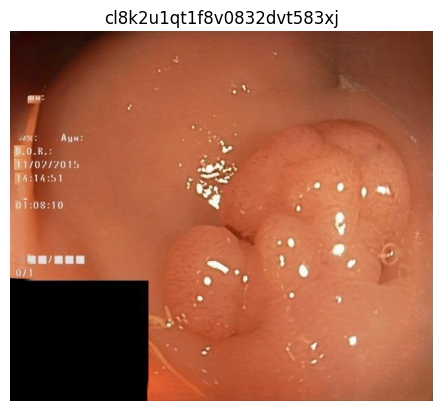

,question,answer
0,Are there any abnormalities in the image?,polyp
1,Are there any anatomical landmarks in the image?,no
2,Are there any instruments in the image?,no
3,Have all polyps been removed?,no
4,How many findings are present?,1
5,How many instruments are in the image?,0
6,How many polyps are in the image?,1
7,Is there a green/black box artefact?,yes
8,Is there text?,yes
9,Is this finding easy to detect?,yes


In [9]:
show_example(df, img_id = 'cl8k2u1qt1f8v0832dvt583xj',qa=True)

## 3. Data Preparation

### Option 3 - OLD+NEW: Train:Val (36000)-9:1 + Test (27620)

In [10]:
abnormality = {i[0]:i[1] for i in df[df.question=='Are there any abnormalities in the image?'][['img_id','answer']].values}

df['abnormality'] =  df['img_id'].apply(lambda x: abnormality[x])



abnormality1 = {i[0]:i[1] for i in df1[df1.question=='Are there any abnormalities in the image?'][['img_id','answer']].values}

test_set['abnormality'] =  test_set['img_id'].apply(lambda x: abnormality1[x] if x in abnormality1.keys() else 'None')

In [ ]:
tmp = df[df.question=='Are there any abnormalities in the image?'][['img_id','answer']] #stratified by abnormality

train, test = train_test_split(tmp,test_size=0.2,random_state=2)

val, test = train_test_split(test,test_size=0.5,shuffle=False)



train = df[df.img_id.isin(train.img_id.tolist() + val.img_id.tolist())]

val = df[df.img_id.isin(test.img_id.tolist())]

test = test_set.copy()



one_hot = MultiLabelBinarizer()

train['labels'] = one_hot.fit_transform(train.answer.str.lower().str.split(', ')).tolist()

val['labels'] = one_hot.transform(val.answer.str.lower().str.split(', ')).tolist()

test['labels'] = one_hot.transform(test.answer.str.lower().str.split(';').apply(lambda x: [i.strip() for i in x])).tolist()

print('Train set:',train.shape)

print('Val set:',val.shape)

print('Test set:',test.shape)

print(one_hot.classes_)

print(len(one_hot.classes_))



one_hot2 = MultiLabelBinarizer()

train['labels_ab'] = one_hot2.fit_transform(train.abnormality.str.lower().str.split(', ')).tolist()

val['labels_ab'] = one_hot2.transform(val.abnormality.str.lower().str.split(', ')).tolist()

test['labels_ab'] = one_hot2.transform(test.abnormality.str.lower().str.split(';').apply(lambda x: [i.strip() for i in x])).tolist()

Train set: (32400, 5)
Val set: (3600, 5)
Test set: (27620, 5)
['0' '1' '11-20mm' '2' '3' '4' '5' '5-10mm' '6' '< 5mm' '>20mm' 'barretts'
 'biopsy forceps' 'black' 'blue' 'brown' 'cecum' 'center' 'center-left'
 'center-right' 'colonoscopy' 'gastroscopy' 'green' 'grey' 'ileum'
 'injection needle' 'ink' 'lower-center' 'lower-left' 'lower-right'
 'metal clip' 'no' 'not relevant' 'oesophagitis' 'orange' 'pale pink'
 'paris iia' 'paris ip' 'paris is' 'pink' 'polyp' 'polyp snare' 'purple'
 'pylorus' 'red' 'tube' 'ulcerative colitis' 'upper-center' 'upper-left'
 'upper-right' 'violet' 'white' 'yellow' 'yes' 'z-line']
55


### Export

In [12]:
train.to_csv(os.path.join("/kaggle/working", "data_train.csv"), index=None)

val.to_csv(os.path.join("/kaggle/working", "data_eval.csv"), index=None)

test.to_csv(os.path.join("/kaggle/working", "data_test.csv"), index=None)

In [13]:
dataset = load_dataset(

    "csv",

    data_files={

        "train": os.path.join("/kaggle/working", "data_train.csv"),

        "val": os.path.join("/kaggle/working", "data_eval.csv")

    }

)

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

In [ ]:
pd.set_option('display.max_colwidth', 0)



def get_answer_dist_by_abnormalities(df,q,do_round=True):

    qs = df.question.unique()

    polyp_id = df[df.answer=='polyp'].img_id.tolist()

    uc_id = df[df.answer=='ulcerative colitis'].img_id.tolist()

    oeso_id = df[df.answer=='oesophagitis'].img_id.tolist()

    no_id = df[(df.question==q) & (df.answer=='no')].img_id.tolist()



    df1 = pd.DataFrame({'question':df.question.unique()})

    ids = {'polyp':polyp_id,'ulcerative colitis':uc_id,'oesophagitis':oeso_id,'no':no_id}

    for k,i in ids.items():

        tmp = df[df.img_id.isin(i)]

        tmp['answer'] = tmp['answer'].str.lower().str.split(',').apply(lambda x: [i.strip() for i in x])#tmp['answer'].str.split(',')

        tmp = tmp.explode('answer')

        if(do_round):

            tmp = {q:(np.round(tmp[tmp.question==q].answer.value_counts()/tmp[tmp.question==q].img_id.unique().shape[0],4)).to_dict() for q in qs}

        else:

            tmp = {q:(tmp[tmp.question==q].answer.value_counts()/tmp[tmp.question==q].img_id.unique().shape[0]).to_dict() for q in qs}

        df1[k] = tmp.values()

    df1.index = df1.question

    df1 = df1.drop('question',axis=1)

    return df1

In [15]:
q1 = 'Are there any abnormalities in the image?'

answer_dist = get_answer_dist_by_abnormalities(df,q1,do_round=True)

answer_dist

,polyp,ulcerative colitis,oesophagitis,no
question,,,,
Are there any abnormalities in the image?,{'polyp': 1.0},{'ulcerative colitis': 1.0},{'oesophagitis': 1.0},{'no': 1.0}
Are there any anatomical landmarks in the image?,"{'no': 0.9837, 'ileum': 0.0082, 'pylorus': 0.0049, 'cecum': 0.0033}","{'not relevant': 0.8603, 'cecum': 0.1337, 'no': 0.006}","{'z-line': 0.9069, 'no': 0.0931}","{'no': 0.9922, 'z-line': 0.0078}"
Are there any instruments in the image?,"{'no': 0.7716, 'tube': 0.1158, 'polyp snare': 0.0881, 'biopsy forceps': 0.0604, 'metal clip': 0.0163, 'injection needle': 0.0016}","{'not relevant': 0.9721, 'tube': 0.014, 'biopsy forceps': 0.01, 'metal clip': 0.004}","{'not relevant': 0.9919, 'tube': 0.0081}","{'tube': 0.8958, 'biopsy forceps': 0.0938, 'metal clip': 0.0156, 'polyp snare': 0.013, 'no': 0.0078}"
Have all polyps been removed?,"{'no': 0.9886, 'yes': 0.0114}",{'not relevant': 1.0},{'not relevant': 1.0},"{'not relevant': 0.974, 'yes': 0.0182, 'no': 0.0078}"
How many findings are present?,"{'1': 0.783, '2': 0.1713, '3': 0.0228, '0': 0.0082, '5': 0.0049, '4': 0.0049, '6': 0.0016, '16': 0.0016, 'pink': 0.0016, 'yellow': 0.0016}","{'1': 0.986, '2': 0.014}","{'2': 0.9069, '1': 0.0931}","{'0': 0.6927, '1': 0.3047, '4': 0.0026}"
How many instruments are in the image?,"{'0': 0.7618, '1': 0.1892, '2': 0.0457, '3': 0.0033}","{'0': 0.9721, '1': 0.0279}","{'0': 0.9939, '1': 0.0061}","{'1': 0.9609, '2': 0.0208, '0': 0.0104, '3': 0.0078}"
How many polyps are in the image?,"{'1': 0.9299, '2': 0.0506, '3': 0.0082, '4': 0.0033, '5': 0.0033, '0': 0.0016, '6': 0.0016, '16': 0.0016}",{'0': 1.0},{'0': 1.0},"{'0': 0.9922, '1': 0.0052, '4': 0.0026}"
Is there a green/black box artefact?,"{'yes': 0.5465, 'no': 0.4535}","{'no': 0.6587, 'yes': 0.3413}","{'no': 0.9028, 'yes': 0.0972}","{'no': 0.6797, 'yes': 0.3203}"
Is there text?,"{'yes': 0.9266, 'no': 0.0734}","{'yes': 0.8882, 'no': 0.1118}","{'no': 0.5567, 'yes': 0.4433}","{'yes': 0.9193, 'no': 0.0807}"


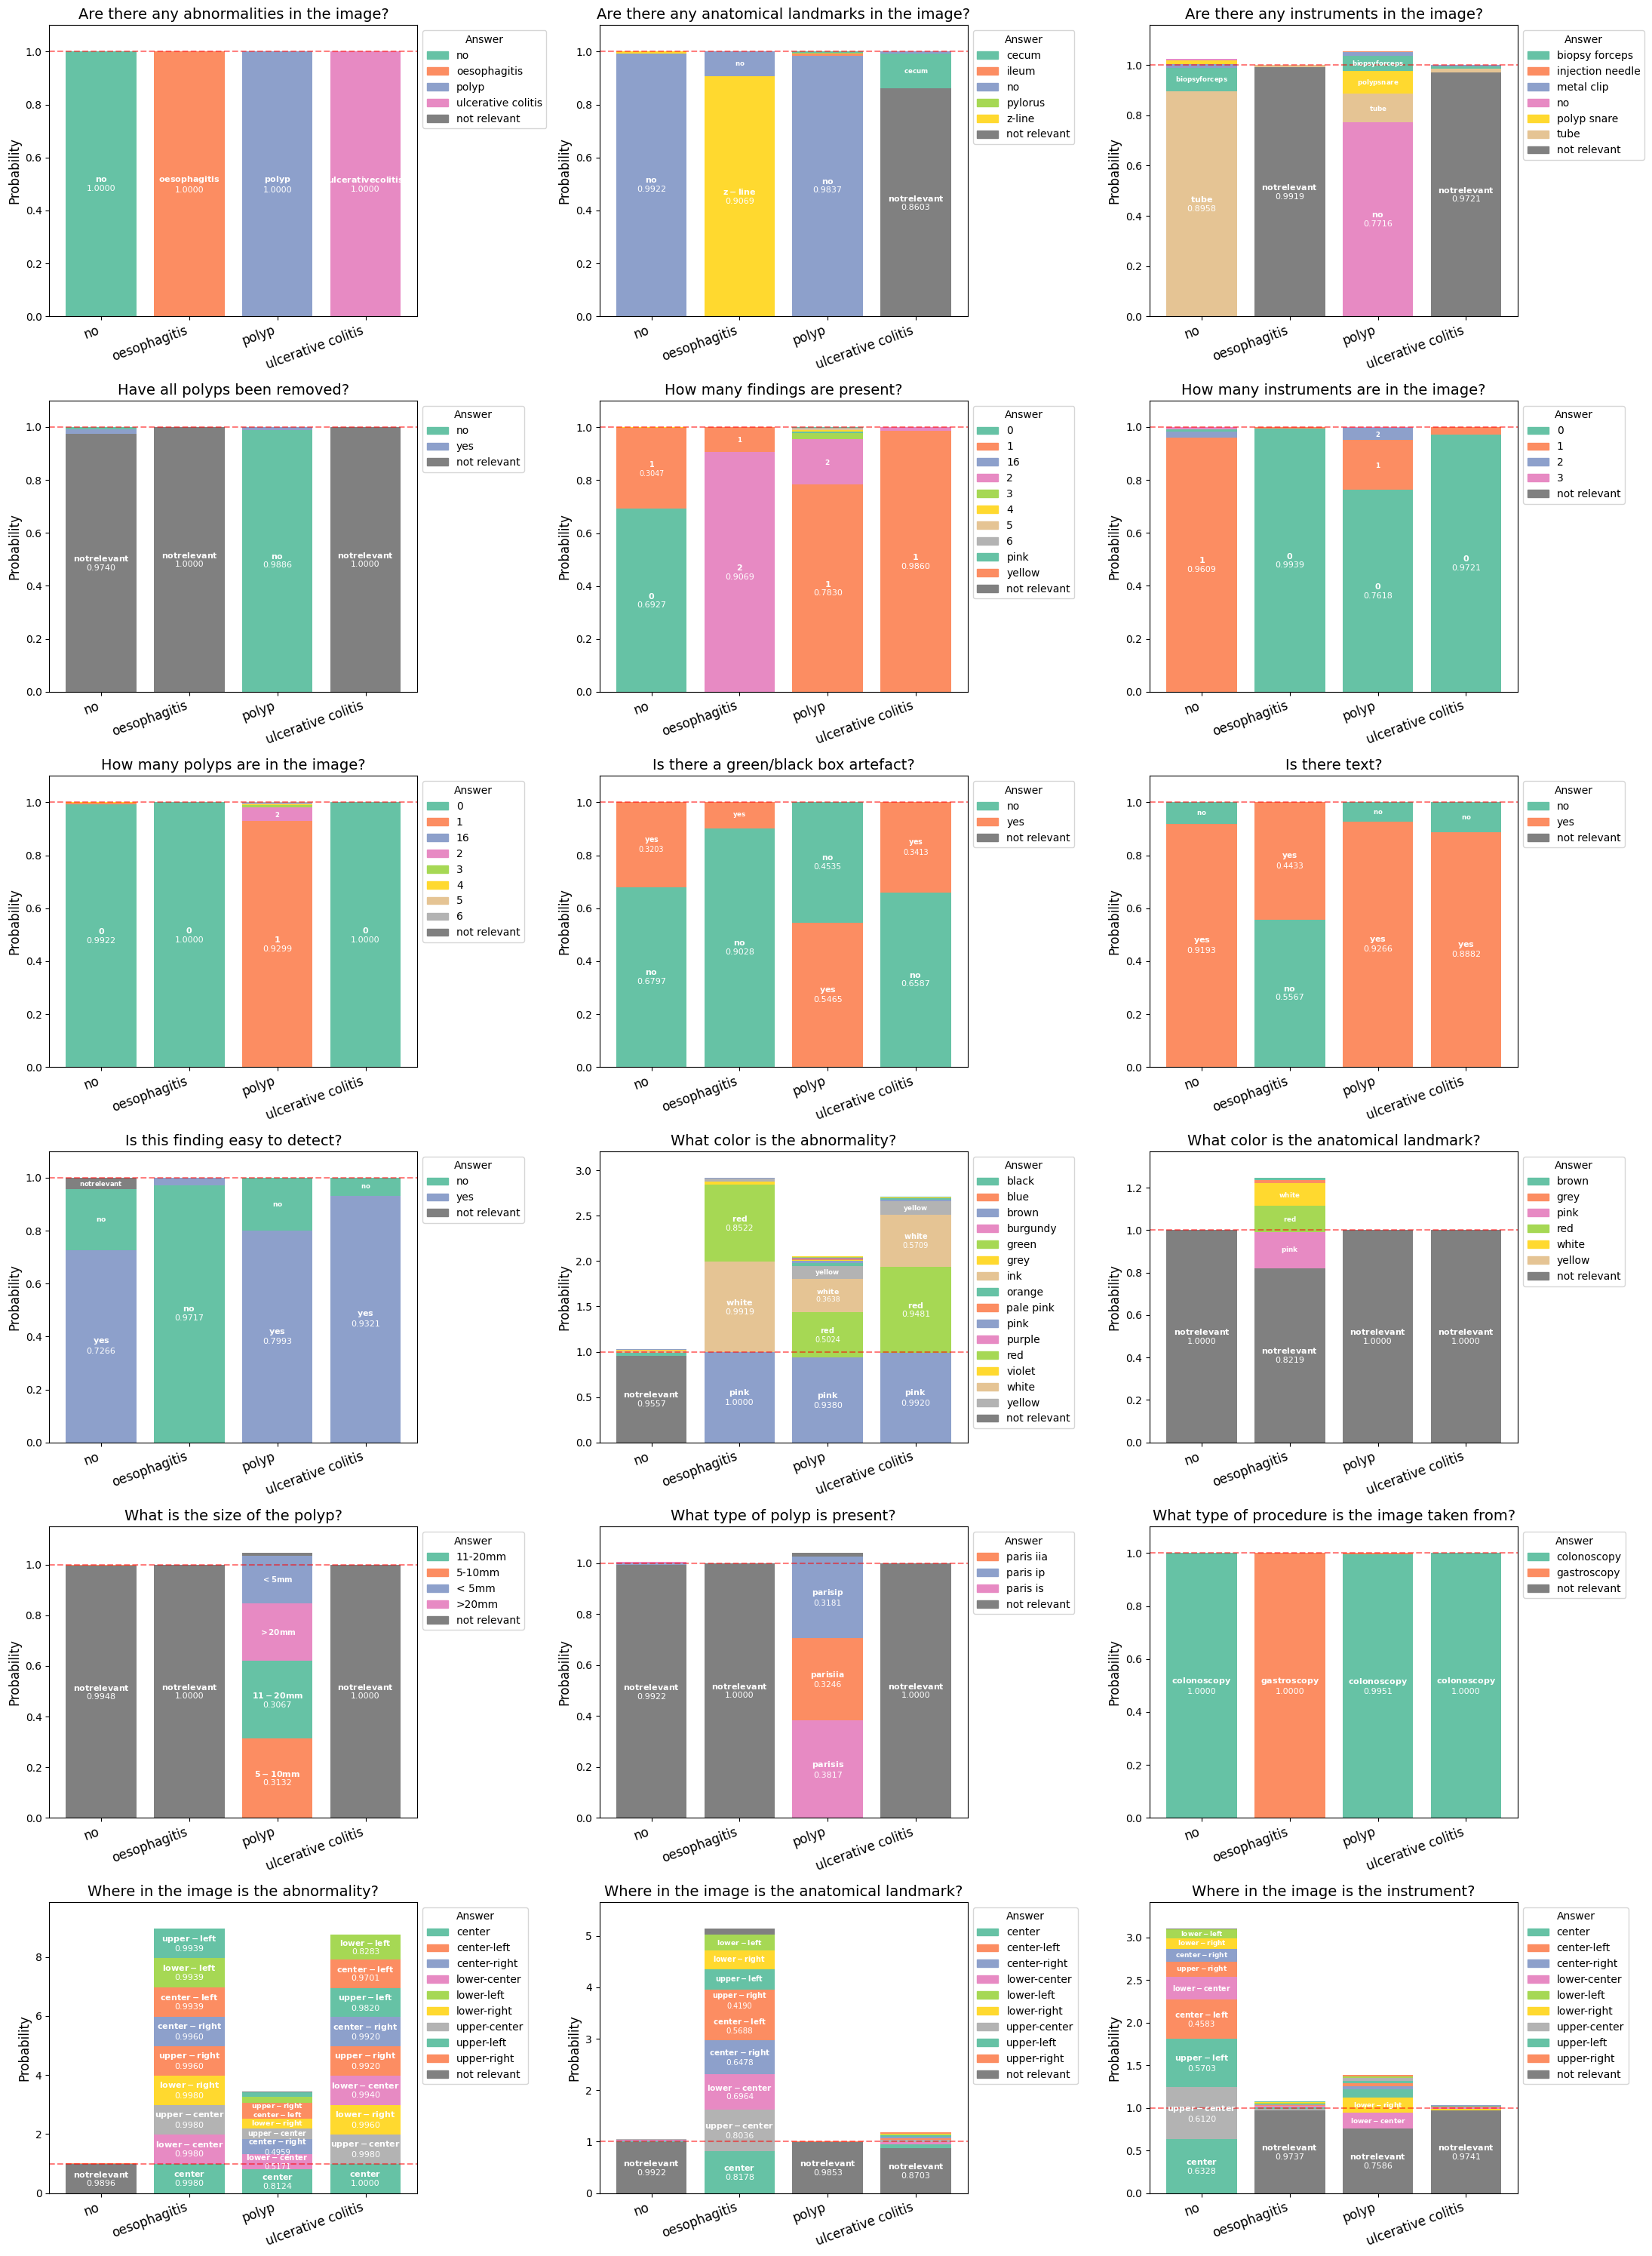

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.patches as mpatches

# --- 1. Flatten dữ liệu ---
def flatten_answer_distribution(answer_dist):
    """
    Chuyển DataFrame answer_dist (index: question, columns: abnormality,
    mỗi ô chứa dict {answer: probability})
    thành DataFrame với các cột: question, abnormality, answer, proportion.
    """
    records = []
    for question in answer_dist.index:
        for abnormality in answer_dist.columns:
            dist_dict = answer_dist.loc[question, abnormality]
            if isinstance(dist_dict, dict):
                for answer, proportion in dist_dict.items():
                    records.append({
                        'question': question,
                        'abnormality': abnormality,
                        'answer': answer,
                        'proportion': proportion
                    })
    return pd.DataFrame(records)

flat_df = flatten_answer_distribution(answer_dist)

questions = np.sort(flat_df['question'].unique())
num_questions = len(questions)

ncols = 3
nrows = math.ceil(num_questions / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(22, 5 * nrows))
axes = axes.flatten()

for idx, question in enumerate(questions):
    ax = axes[idx]
    df_q = flat_df[flat_df['question'] == question]
    pivot = df_q.pivot(index='abnormality', columns='answer', values='proportion').fillna(0)
    abnormalities = list(pivot.index)
    x = np.arange(len(abnormalities))
    bar_width = 0.8

    set2_colors = plt.get_cmap("Set2").colors
    answers_local = np.sort(df_q['answer'].unique())
    
    local_color_map = {ans: set2_colors[i % len(set2_colors)] for i, ans in enumerate(answers_local)}
    
    if 'not relevant' in answers_local:
        local_color_map['not relevant'] = 'gray'

    max_total = pivot.sum(axis=1).max()
    if max_total >= 6:
        annotate_threshold = 0.25
    elif max_total >= 4 and max_total < 6:
        annotate_threshold = 0.2
    elif max_total >= 2 and max_total < 4:
        annotate_threshold = 0.1
    else:
        annotate_threshold = 0.04
    
    for j, ab in enumerate(abnormalities):
        row = pivot.loc[ab]
        sorted_row = row.sort_values(ascending=False)
        max_prop_col = sorted_row.max() if not sorted_row.empty else 0
        bottom = 0
        for answer, prop in sorted_row.items():
            if prop <= 0:
                continue
            ax.bar(j, prop, bar_width, bottom=bottom, color=local_color_map[answer])
            if prop >= annotate_threshold and max_prop_col > 0:
                base_font = 8
                min_font = 6
                fontsize = min_font + (base_font - min_font) * (prop / max_prop_col)
                if prop >= annotate_threshold + 0.2:
                    text_str = r"$\mathbf{%s}$" % answer + "\n" + f"{prop:.4f}"
                else:
                    text_str = r"$\mathbf{%s}$" % answer
                ax.text(j, bottom + prop/2, text_str,
                        ha='center', va='center', color='white', fontsize=fontsize)
            bottom += prop

    ax.set_title(question, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(abnormalities, rotation=20, ha='right', fontsize=12)
    ax.set_ylabel("Probability", fontsize=12)
    ax.set_ylim(0, max_total * 1.1)
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax.grid(False)
    
    patches = [mpatches.Patch(color=local_color_map[ans], label=ans) for ans in answers_local if ans != 'not relevant']
    patches.append(mpatches.Patch(color='gray', label='not relevant'))  # Đưa 'not relevant' vào cuối legend và chọn màu xám
    ax.legend(handles=patches, title="Answer", loc='upper left', bbox_to_anchor=(1, 1),
              fontsize=10, title_fontsize=10)

for i in range(idx+1, len(axes)):
    fig.delaxes(axes[i])
    
fig.subplots_adjust(right=0.85, top=0.95, bottom=0.1, left=0.05)
plt.tight_layout()
plt.savefig(f'answer_distribution.png', dpi=200, bbox_inches='tight')
plt.show()


### 4.2. Attention-on-Attention Architecture

In [ ]:
class FC(nn.Module):

    def __init__(self, in_size, out_size, dropout_r=0., use_relu=True):

        super(FC, self).__init__()

        self.dropout_r = dropout_r

        self.use_relu = use_relu

        self.linear = nn.Linear(in_size, out_size)

        if use_relu:

            self.relu = nn.GELU()

        if dropout_r > 0:

            self.dropout = nn.Dropout(dropout_r)



    def forward(self, x):

        x = self.linear(x)

        if self.use_relu:

            x = self.relu(x)

        if self.dropout_r > 0:

            x = self.dropout(x)

        return x



class MLP(nn.Module):

    def __init__(self, in_size, mid_size, out_size, dropout_r=0., use_relu=True):

        super(MLP, self).__init__()

        self.fc = FC(in_size, mid_size, dropout_r=dropout_r, use_relu=use_relu)

        self.linear = nn.Linear(mid_size, out_size)



    def forward(self, x):

        return self.linear(self.fc(x))



class LayerNorm(nn.Module):

    def __init__(self, size, eps=1e-6):

        super(LayerNorm, self).__init__()

        self.eps = eps

        self.a_2 = nn.Parameter(torch.ones(size))

        self.b_2 = nn.Parameter(torch.zeros(size))



    def forward(self, x):

        mean = x.mean(-1, keepdim=True)

        std = x.std(-1, keepdim=True)

        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2



class AttFlat(nn.Module):

    def __init__(self, feat_dim):

        super(AttFlat, self).__init__()

        self.mlp = MLP(in_size= feat_dim,

                       mid_size= feat_dim,

                       out_size= 1,

                       dropout_r= 0.1,

                       use_relu=True)

        self.linear_merge = nn.Linear(feat_dim * 1, feat_dim)



    def forward(self, x, x_mask):

        att = self.mlp(x)

        att = att.masked_fill(x_mask.squeeze(1).squeeze(1).unsqueeze(2), -1e9)

        att = F.softmax(att, dim=1)

        att_list = []

        for i in range(1):

            att_list.append(

                torch.sum(att[:, :, i: i + 1] * x, dim=1))

        x_atted = torch.cat(att_list, dim=1)

        x_atted = self.linear_merge(x_atted)

        return x_atted

In [18]:
class SAoA(nn.Module):
    def __init__(self, feat_dim, heads=8):
        super(SAoA, self).__init__()
        self.AoA1 = AoA(dim=feat_dim, heads=heads)

    def forward(self, x):
        x = x + self.AoA1(x)
        return x

class GAoA(nn.Module):
    def __init__(self, feat_dim, heads=8):
        super(GAoA, self).__init__()
        self.AoA1 = AoA(dim=feat_dim, heads=heads)

    def forward(self, x, context):
        x = x + self.AoA1(x, context = context)
        return x

In [19]:
class SAoA(nn.Module):

    def __init__(self, feat_dim, heads=8):

        super(SAoA, self).__init__()

        self.AoA = AoA(dim=feat_dim, heads=heads)

        self.norm1 = LayerNorm(feat_dim)

        self.norm2 = LayerNorm(feat_dim)


        self.ffn = MLP(in_size= feat_dim,

                       mid_size= feat_dim,
        
                       out_size= feat_dim,
        
                       dropout_r= 0.1,
        
                       use_relu=True)



    def forward(self, x):

        x = self.norm1(x + 
            self.AoA(x)
        )

        x = self.norm2(x + 
            self.ffn(x)
        )

        return x

class GAoA(nn.Module):

    def __init__(self, feat_dim, heads=8):

        super(GAoA, self).__init__()

        self.AoA = AoA(dim=feat_dim, heads=heads)

        self.norm1 = LayerNorm(feat_dim)

        self.norm2 = LayerNorm(feat_dim)


        self.ffn = MLP(in_size= feat_dim,

                       mid_size= feat_dim,
        
                       out_size= feat_dim,
        
                       dropout_r= 0.1,
        
                       use_relu=True)



    def forward(self, x, context):

        x = self.norm1(x + 
            self.AoA(x, context = context)
        )

        x = self.norm2(x + 
            self.ffn(x)
        )

        return x

### 4.3. VQA integrate answer distribution

In [ ]:
class MultimodalVQAModel2(nn.Module):

    def __init__(self,  pretrained_text_name, pretrained_image_name, num_labels=len(one_hot.classes_)):

        super(MultimodalVQAModel2, self).__init__()

        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)
        self.feat_dim = self.image_encoder.config.hidden_size

        self.enc_list = nn.ModuleList([SAoA(feat_dim=self.feat_dim, heads=8) for _ in range(1)])
        self.dec_list = nn.ModuleList([GAoA(feat_dim=self.feat_dim, heads=8) for _ in range(1)])

        self.enc_list1 = nn.ModuleList([SAoA(feat_dim=self.feat_dim, heads=8) for _ in range(1)])
        self.dec_list1 = nn.ModuleList([GAoA(feat_dim=self.feat_dim, heads=8) for _ in range(1)])

        self.attflat_img = AttFlat(self.feat_dim)
        self.attflat_lang = AttFlat(self.feat_dim)

        self.fusion = nn.Sequential(
                      nn.Linear(self.feat_dim*2,self.feat_dim*2),
                      nn.Dropout(0.2),
                      nn.Linear(self.feat_dim*2,self.feat_dim),
                      nn.Dropout(0.2),
                      nn.Linear(self.feat_dim,2),
                      nn.Softmax(dim=1)
        )

        self.proj_norm = LayerNorm(self.feat_dim)
        self.classifier = nn.Linear(self.feat_dim, self.num_labels)
        self.criterion = nn.BCEWithLogitsLoss() #BCE for multi-label classification

    def make_mask(self,feature):
        return (torch.sum(torch.abs(feature),dim=-1) == 0).unsqueeze(1).unsqueeze(2)

    def get_img_model(self,):
        return self.image_encoder

    def forward(self,
                input_ids: torch.LongTensor,
                pixel_values: torch.FloatTensor,
                attention_mask: Optional[torch.LongTensor] = None,
                token_type_ids: Optional[torch.LongTensor] = None,
                labels: Optional[torch.LongTensor] = None):

        output_encoded_text = self.text_encoder(input_ids=input_ids,
                                         attention_mask=attention_mask,
                                         return_dict=True,output_attentions=True)
        
        encoded_text = output_encoded_text['last_hidden_state']

        output_encoded_image = self.image_encoder(pixel_values=pixel_values,
                                                 return_dict=True,output_attentions=True)

        encoded_image = output_encoded_image['last_hidden_state'][:,1:,:] #ignore [CLS] token

        q_feat_mask = self.make_mask(encoded_text)
        img_feat_mask = self.make_mask(encoded_image)

        encoded_image_clone = encoded_image.clone()

        for _ in range(1):
            for dec in self.dec_list:
                encoded_image = dec(encoded_image, context = encoded_text)

        for _ in range(1):
            for dec in self.dec_list1:
                encoded_text = dec(encoded_text, context = encoded_image_clone)

        for _ in range(1):
            for enc in self.enc_list:
                encoded_text = enc(encoded_text)

        for _ in range(1):
            for enc in self.enc_list1:
                encoded_image = enc(encoded_image)

        lang_feat = self.attflat_lang(encoded_text,q_feat_mask)
        img_feat = self.attflat_img(encoded_image,img_feat_mask)

        #new fusion (MCAoAN)
        x = torch.cat([lang_feat,img_feat],dim=1)
        w =  self.fusion(x)
        q_w, i_w = lang_feat*w[:,[0]], img_feat*w[:,[1]],
        x = lang_feat + q_w + img_feat + i_w
        x = self.proj_norm(x)

        logits = self.classifier(x)

        out = {"logits": logits}

        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss


        return out

## 5. Multimodal Collator

In [ ]:
@dataclass

class MultimodalCollator:

    tokenizer: AutoTokenizer

    preprocessor: AutoFeatureExtractor#get_feature_extractor



    def tokenize_text(self, texts: List[str]):

        encoded_text = self.tokenizer(

            text=texts,

            padding='longest',

            max_length=15,

            truncation=True,

            return_tensors='pt',

            return_token_type_ids=True,

            return_attention_mask=True,

        )

        return {

            "input_ids": encoded_text['input_ids'].squeeze(),

            "token_type_ids": encoded_text['token_type_ids'].squeeze(),

            "attention_mask": encoded_text['attention_mask'].squeeze(),

        }



    def preprocess_images(self, images: List[str]):

        processed_images = self.preprocessor(images=[Image.open(imgp + image_id + ".jpg").convert('RGB') for image_id in images],

                                             return_tensors="pt",)

        return {"pixel_values": processed_images['pixel_values'].squeeze(),}



    def __call__(self, raw_batch_dict):

        return {

            **self.tokenize_text(

                raw_batch_dict['question']

                if isinstance(raw_batch_dict, dict) else

                [i['question'] for i in raw_batch_dict]

            ),

            **self.preprocess_images(

                raw_batch_dict['img_id']

                if isinstance(raw_batch_dict, dict) else

                [i['img_id'] for i in raw_batch_dict]

            ),

            'labels': torch.tensor(

                raw_batch_dict['labels']

                if isinstance(raw_batch_dict, dict) else

                [ast.literal_eval(i['labels']) for i in raw_batch_dict],

                dtype=torch.float32

            ),
        }

In [22]:
def createMultimodalVQACollatorAndModel(text, image, model_name = 'baseline',**kwargs):

    # Initialize the correct text tokenizer and image feature extractor, and use them to create the collator

    tokenizer = AutoTokenizer.from_pretrained(text)

    preprocessor = get_feature_extractor(image)

    multimodal_collator = MultimodalCollator(tokenizer=tokenizer, preprocessor=preprocessor)

    if(model_name=='baseline'):

        multimodal_model = MultimodalVQAModel1(pretrained_text_name=text,

                                              pretrained_image_name=image,).to(device)

    elif(model_name=='mcaoan'):

        multimodal_model = MultimodalVQAModel2(pretrained_text_name=text,

                                              pretrained_image_name=image,).to(device)

    return multimodal_collator, multimodal_model, tokenizer, preprocessor

## 6. Model Training

### 6.1. Model Configurations

**CHOOSE PRE-TRAINED MODEL HERE**



**Language model (BASE version)**

* **ClinicalBERT:** 'medicalai/ClinicalBERT'

* **BioBERT:** 'dmis-lab/biobert-v1.1'





**Transformer-based vision model (BASE version)**

* **ViT:** 'google/vit-base-patch16-224-in21k'

* **BeiT:** 'microsoft/beit-base-patch16-224-pt22k-ft22k'

In [23]:
# Choose model here

TEXT_MODEL = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'

IMG_MODEL = 'microsoft/beit-base-patch16-224-pt22k-ft22k'


MODEL_NAME = 'mcaoan' #['baseline','mcaoan']



imgp = imgp2

### 6.2. Training Configurations

In [24]:
set_SEED()

lr = 1e-4 #learning rate

wr = 0.05 #warmup ratio

wd = 0.2 #weight decay

gradient_accumulation_steps = 2

batch_size = 64 #64

epochs = 15

seed = 42

num_steps = 100 #100



multi_args = TrainingArguments(

    output_dir = "checkpoint",

    learning_rate = lr,

    warmup_ratio = wr,

    weight_decay = wd,

    gradient_accumulation_steps = gradient_accumulation_steps,

    seed = seed,

    evaluation_strategy = 'epoch',

    logging_strategy = 'epoch',

    save_strategy = 'epoch',

    save_total_limit = 3,

    eval_steps = None,

    logging_steps = None,

    save_steps = None,

    metric_for_best_model = 'F1',

    per_device_train_batch_size = batch_size,

    per_device_eval_batch_size = batch_size,

    remove_unused_columns = False,

    num_train_epochs = epochs,

    fp16 = False,

    dataloader_num_workers = 2,

    load_best_model_at_end = True,

    disable_tqdm = False,
    # max_steps = 100

)



torch.cuda.empty_cache()
torch.cuda.empty_cache()


collator, model, tokenizer, preprocessor = createMultimodalVQACollatorAndModel(text = TEXT_MODEL,

                                                                               image = IMG_MODEL,

                                                                               model_name = MODEL_NAME,

                                                                              )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

In [25]:
encoded_q = tokenizer(

            text=train.question.unique().tolist(),

            padding='longest',

            max_length=15,

            truncation=True,

            return_tensors='pt',

            return_token_type_ids=True,

            return_attention_mask=True,

        )['input_ids']

d = {k:v for k,v in zip(train.question.unique().tolist(),encoded_q)}



q1 = 'Are there any abnormalities in the image?'

answer_dist = get_answer_dist_by_abnormalities(df,q1,do_round=False)

answer_dist = answer_dist.reset_index()

answer_dist['question_id'] = answer_dist['question'].apply(lambda x: np.sum(d[x].numpy()))

answer_dist = answer_dist.set_index('question_id')



def get_answer_weight(question_id,abnormality,one_hot=one_hot):

    if(abnormality not in answer_dist.columns):

        return list(np.ones(len(one_hot.classes_)))



    d = answer_dist.loc[question_id,abnormality]

    w = [d[i] if i in d.keys() else 0 for i in one_hot.classes_ ]

    #w = [1 if i!=0 else 0 for i in w]

    return w



question_id = np.sum(d['What color is the abnormality?'].numpy())

print(get_answer_weight(question_id,'polyp'))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009787928221859706, 0.021207177814029365, 0, 0, 0, 0, 0, 0, 0.004893964110929853, 0.011419249592169658, 0, 0, 0.0016313213703099511, 0, 0, 0, 0, 0, 0.008156606851549755, 0, 0.03588907014681892, 0.0016313213703099511, 0, 0, 0, 0.9380097879282219, 0, 0, 0.008156606851549755, 0, 0.5024469820554649, 0, 0, 0, 0, 0, 0.0016313213703099511, 0.3637846655791191, 0.13866231647634583, 0, 0]


In [26]:
print('Train set:',train.shape)

print('Val set:',val.shape)

print('Test set:',test.shape)

print(one_hot.classes_)

print(len(one_hot.classes_))

Train set: (32400, 6)
Val set: (3600, 6)
Test set: (27620, 6)
['0' '1' '11-20mm' '2' '3' '4' '5' '5-10mm' '6' '< 5mm' '>20mm' 'barretts'
 'biopsy forceps' 'black' 'blue' 'brown' 'cecum' 'center' 'center-left'
 'center-right' 'colonoscopy' 'gastroscopy' 'green' 'grey' 'ileum'
 'injection needle' 'ink' 'lower-center' 'lower-left' 'lower-right'
 'metal clip' 'no' 'not relevant' 'oesophagitis' 'orange' 'pale pink'
 'paris iia' 'paris ip' 'paris is' 'pink' 'polyp' 'polyp snare' 'purple'
 'pylorus' 'red' 'tube' 'ulcerative colitis' 'upper-center' 'upper-left'
 'upper-right' 'violet' 'white' 'yellow' 'yes' 'z-line']
55


In [27]:
multi_trainer = Trainer(model,

                        multi_args,

                        train_dataset = dataset['train'],

                        eval_dataset = dataset['val'],

                        data_collator = collator,

                        compute_metrics = compute_metrics)



print('Number of trainable paramaters:',sum(p.numel() for p in model.parameters()))

Number of trainable paramaters: 216947963


### 6.3. Train Model

In [ ]:
import os
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.cuda.empty_cache()

train_multi_metrics = multi_trainer.train()

eval_multi_metrics = multi_trainer.evaluate()

### 6.4. Visualizing Loss

In [29]:
# save loss

log_history = {'log_history':multi_trainer.state.log_history}



with open('logs.json', 'w', encoding='utf-8') as f:

    json.dump(log_history, f, ensure_ascii=False, indent=4)

In [ ]:
train_loss = []

val_loss = []



val_metrics = {'eval_Accuracy':[],'eval_F1':[]}

for i in log_history['log_history']:

    if('loss' in i.keys()):

        train_loss.append(i['loss'])



    if('eval_loss' in i.keys()):

        val_loss.append(i['eval_loss'])

        val_metrics['eval_Accuracy'].append(i['eval_Accuracy'])

        val_metrics['eval_F1'].append(i['eval_F1'])

plt.plot(train_loss)

plt.plot(val_loss)

plt.legend(['Train loss','Validation loss'])

plt.show()



plt.plot(val_metrics['eval_Accuracy'])

plt.plot(val_metrics['eval_F1'])

plt.legend(['Validation Accuracy','Validation F1'])

plt.show()

## 7. Evaluate Model Performance

In [31]:
f1_by_step = {i['step']:i['eval_F1'] for i in log_history['log_history'] if 'eval_F1'in i.keys()}

best_f1_step = max(f1_by_step, key=f1_by_step.get)

#best_f1_step = 2800

best_f1_step

1521

In [ ]:
from transformers import AutoModelForSequenceClassification
import os
import torch

# Tạo collator, model, tokenizer, preprocessor
collator, model, tokenizer, preprocessor = createMultimodalVQACollatorAndModel(
    text=TEXT_MODEL,
    image=IMG_MODEL,
    model_name=MODEL_NAME,
)

# Chọn checkpoint path
checkpoint_dir = os.path.join("/kaggle/working/checkpoint", f"checkpoint-{best_f1_step}")
safetensor_path = os.path.join(checkpoint_dir, "model.safetensors")
pytorch_path = os.path.join(checkpoint_dir, "pytorch_model.bin")

# Load model tùy theo file nào có sẵn
if os.path.exists(pytorch_path):
    print(f"Đang load mô hình từ {pytorch_path} (pytorch_model.bin)")
    model.load_state_dict(torch.load(pytorch_path))
elif os.path.exists(safetensor_path):
    print(f"Đang load mô hình từ {safetensor_path} (model.safetensors)")
    from safetensors.torch import load_file
    model.load_state_dict(load_file(safetensor_path))
else:
    raise FileNotFoundError("Không tìm thấy mô hình nào trong checkpoint.")

# Đưa model về thiết bị
model.to(device)
model.eval()

In [ ]:
import tqdm

import seaborn as sns

pred_val = []
pred_test = []

for set_, preds in zip([val.copy(),test.copy()],

                       [pred_val,pred_test]):

    for x,y in tqdm.tqdm_notebook(zip(batch(set_.img_id, batch_size),batch(set_.question, batch_size)),total=int(set_.shape[0]/batch_size)):

        imgpath = [imgp + i +'.jpg' for i in x]

        q = y.values

        p = predict(q,imgpath,model)

        preds.append(p)


pred_val = np.concatenate(pred_val, axis=0)

pred_test = np.concatenate(pred_test, axis=0)

In [34]:
pred_val_df = val.copy()

pred_val_df['preds'] = get_answer(pred_val).tolist()

pred_val_df['predicted_answer'] = [', '.join(i) for i in one_hot.inverse_transform(np.array( get_answer(pred_val)))]

pred_val_df['probs'] = [dict(Counter( {k:v for k,v in zip(one_hot.classes_,i)}).most_common(55)) for i in pred_val]



pred_test_df = test.copy()

pred_test_df['preds'] = get_answer(pred_test).tolist()

pred_test_df['predicted_answer'] = [', '.join(i) for i in one_hot.inverse_transform(np.array( get_answer(pred_test)))]

pred_test_df['probs'] = [dict(Counter( {k:v for k,v in zip(one_hot.classes_,i)}).most_common(55)) for i in pred_test]

In [ ]:
val_result = evaluate(pred_val_df)

test_result = evaluate(pred_test_df)



result_df = pd.DataFrame({'Accuracy':[val_result[0],test_result[0]],

                              'Precision':[val_result[1],test_result[1]],

                              'Recall':[val_result[2],test_result[2]],

                              'F1':[val_result[3],test_result[3]]},index=['Validation set','Test set'])

result_df_html = result_df.style.set_table_styles([{'selector': 'th', 'props': [('font-size', '13pt')]}]).set_properties(**{'font-size': '13pt'}).format('{:.4f}')

result_df_html

In [ ]:
result_qdf = pd.DataFrame(columns=['Question','Accuracy','Precision','Recall','F1'])

for q in pred_test_df.question.unique():

    q_df = pred_test_df[pred_test_df.question==q]

    g = q_df['labels'].tolist()

    p = q_df['preds'].tolist()

    acc = accuracy_score(g,p)

    pre = precision_score(g,p,average='samples')

    rec = recall_score(g,p,average='samples')

    f1 = f1_score(g,p,average='samples')

    result_qdf.loc[len(result_qdf)] = [q,acc,pre,rec,f1]

result_qdf = result_qdf.sort_values('Accuracy')

result_qdf.loc[len(result_qdf)] = ['All',test_result[0],test_result[1],test_result[2],test_result[3]]

result_qdf.style.background_gradient(cmap='Purples')

In [ ]:
from transformers import AutoModel,AutoImageProcessor

import cv2



def plot_attention_map(original_img, att_map,n):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5, 5))

    ax1.set_title('Original')

    ax2.set_title(f'Attention Map Layer {n+1}')

    _ = ax1.imshow(original_img)

    ax1.axis('off')


    tmp = np.array(original_img)

    heatmapshow = None

    heatmapshow = cv2.normalize(att_map, heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_TURBO)

    heatmapshow = cv2.cvtColor(heatmapshow, cv2.COLOR_BGR2RGB)

    final = cv2.addWeighted(src1=tmp,alpha=0.5,src2=heatmapshow,beta=0.5,gamma=0)

    ax2.axis('off')

    plt.imshow(final)



img_id = df.loc[df.answer=='polyp','img_id'].sample().values[0]

print(img_id)

img = imgp+img_id+'.jpg'

img1 = Image.open(img).convert('RGB')



image_encoder = model.get_img_model()

img_prep = preprocessor(images=[img1],return_tensors="pt")['pixel_values'].cuda()

out = image_encoder(pixel_values=img_prep,return_dict=True,output_attentions=True)



att_mat = torch.mean(out['attentions'][-1], dim=1) #last layer



for idx,l in enumerate([out['attentions'][-1]]):

    att_mat = torch.mean(l, dim=1)



    residual_att = torch.eye(att_mat.size(1)).cuda()

    aug_att_mat = att_mat + residual_att

    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)


    joint_attentions = torch.zeros(aug_att_mat.size())

    joint_attentions[0] = aug_att_mat[0]



    for n in range(1, aug_att_mat.size(0)):

        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])



    v = joint_attentions[-1]

    grid_size = int(np.sqrt(aug_att_mat.size(-1)))

    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()



    get_mask = True

    if get_mask:

        result = cv2.resize(mask / mask.max(), img1.size)

    else:

        mask = cv2.resize(mask / mask.max(), img1.size)[..., np.newaxis]

        result = (mask * img1).astype("uint8")

    plot_attention_map(img1,result, idx)

    display(pred_val_df[pred_val_df.img_id==img_id][['question','answer','predicted_answer']])